# Sprint アンサンブル学習

## 1.このSprintについて

### Sprintの目的
- アンサンブル学習について理解する

### どのように学ぶか
- スクラッチでアンサンブル学習の各種手法を実装していきます。



## 2.アンサンブル学習

3種類のアンサンブル学習をスクラッチ実装していきます。そして、それぞれの効果を小さめのデータセットで確認します。

- ブレンディング
- バギング
- スタッキング

### 小さなデータセットの用意
以前も利用した回帰のデータセットを用意します。

<a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data" style="text-decoration:none">
House Prices: Advanced Regression Techniques
</a>


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使います。

train.csvを学習用（train）8割、検証用（val）2割に分割してください。

## scikit-learn
単一のモデルはスクラッチ実装ではなく、scikit-learnなどのライブラリの使用を推奨します。

sklearn.linear_model.LinearRegression — scikit-learn 0.21.3 documentation

sklearn.svm.SVR — scikit-learn 0.21.3 documentation

sklearn.tree.DecisionTreeRegressor — scikit-learn 0.21.3 documentation

In [1]:
# ライブラリインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
# データ読み込み
df = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
df = df[['GrLivArea', 'YearBuilt', 'SalePrice']]
df.head()

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000


In [3]:
df.isnull().sum()

GrLivArea    0
YearBuilt    0
SalePrice    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   GrLivArea  1460 non-null   int64
 1   YearBuilt  1460 non-null   int64
 2   SalePrice  1460 non-null   int64
dtypes: int64(3)
memory usage: 34.3 KB


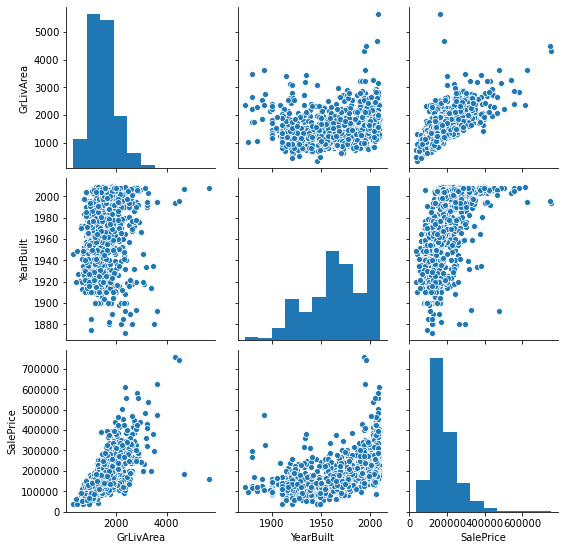

In [5]:
sns.pairplot(df)
plt.show()

In [6]:
# データ分割
X_train, X_test, y_train, y_test = train_test_split(df[['GrLivArea', 'YearBuilt']], df['SalePrice'], test_size=.3, random_state=0)

In [7]:
# 標準化
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [8]:
# yの対数変換
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

## 3.ブレンディング

## 【問題1】ブレンディングのスクラッチ実装
ブレンディング をスクラッチ実装し、単一モデルより精度があがる例を 最低3つ 示してください。精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを指します。



### ブレンディングとは
ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。

 
- 手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
- ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
- 入力データの前処理の仕方（例：標準化、対数変換、PCAなど）

重要なのはそれぞれのモデルが大きく異なることです。


回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。


《補足》


分類問題の場合は、多数決を行います。回帰問題に比べると複雑なため、scikit-learnにはVotingClassifierが用意されています。


sklearn.ensemble.VotingClassifier — scikit-learn 0.21.3 documentation

In [9]:
# MSE(平均二乗誤差)
def print_mse(y_train, y_pred_train, y_test, y_pred):
    mse_train = metrics.mean_squared_error(y_train, y_pred_train)
    mse = metrics.mean_squared_error(y_test, y_pred)
    print('MSE(平均二乗誤差)(train) : {:,.3f}'.format(mse_train))
    print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(mse))

In [10]:
# ブレンディング可視化用
def blend_test(y_train, y_test, y_pred_train_1, y_pred_1, y_pred_train_2, y_pred_2, train=True):
    mse_train_list = []
    mse_list = []
    x_list = []
    for i in np.arange(0.01, 1, 0.01):
        rate_a = i
        rate_b = 1 - i
        
        if train:
            blend1_ypred_train = y_pred_train_1*rate_a + y_pred_train_2*rate_b
        blend1_ypred = y_pred_1*rate_a + y_pred_2*rate_b

        # MSE
        if train:
            mse_train = metrics.mean_squared_error(y_train, blend1_ypred_train)
        mse = metrics.mean_squared_error(y_test, blend1_ypred)

        x_list.append(i)
        if train:
            mse_train_list.append(mse_train)
        mse_list.append(mse)
    if train:
        plt.plot(x_list, mse_train_list)
        plt.title('Train')
        plt.xlabel('rate_a')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()
    plt.plot(x_list, mse_list)
    plt.title('Test')
    plt.xlabel('rate_a')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()
    
    idx = np.argmin(mse_list)
    print('Min MSE =', mse_list[idx])
    print("rate = {:.2f} : {:.2f}".format(x_list[idx], 1-x_list[idx]))

### 単一の学習を実行

In [11]:
# 線形回帰　学習・予測
np.random.seed(0)
lr1 = LinearRegression()
lr1.fit(X_train, y_train)
lr1_ypred_train = lr1.predict(X_train)
lr1_ypred = lr1.predict(X_test)

# MSE
print_mse(y_train, lr1_ypred_train, y_test, lr1_ypred)

MSE(平均二乗誤差)(train) : 1,969,758,679.323
MSE(平均二乗誤差)(test) : 2,690,647,926.378


In [12]:
# SVR　学習・予測
np.random.seed(0)
sv1 = SVR()
sv1.fit(X_train, y_train)
sv1_ypred_train = sv1.predict(X_train)
sv1_ypred = sv1.predict(X_test)

# MSE
print_mse(y_train, sv1_ypred_train, y_test, sv1_ypred)

MSE(平均二乗誤差)(train) : 6,400,941,601.176
MSE(平均二乗誤差)(test) : 7,130,991,127.200


In [13]:
# 決定木回帰　学習・予測
np.random.seed(0)
dt1 = DecisionTreeRegressor(criterion='mse')
dt1.fit(X_train, y_train)
dt1_ypred_train = dt1.predict(X_train)
dt1_ypred = dt1.predict(X_test)

# MSE
print_mse(y_train, dt1_ypred_train, y_test, dt1_ypred)

MSE(平均二乗誤差)(train) : 18,849,495.975
MSE(平均二乗誤差)(test) : 2,297,233,115.183


### ★ブレンディングテスト(1)

最初なので、ひとまず線形回帰と決定木回帰で純粋にブレンド。

重みづけは最適な点を調査して決定する。

#### 【結果】
MSE（線形回帰：2,690,647,926、決定木：2,297,233,115）　から　MSE：1,907,549,936　へ改善


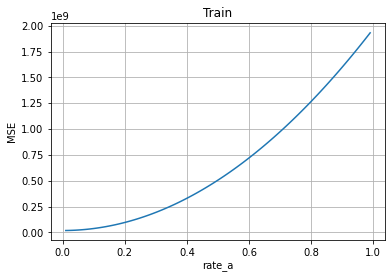

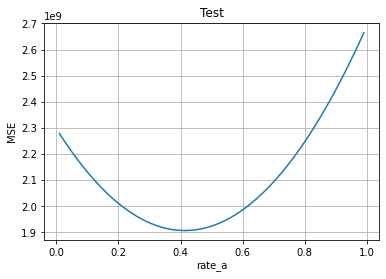

Min MSE = 1907549936.083823
rate = 0.41 : 0.59


In [14]:
blend_test(y_train, y_test, lr1_ypred_train, lr1_ypred, dt1_ypred_train, dt1_ypred)

In [15]:
# ブレンディング
rate_a = 0.4
rate_b = 1 - rate_a

blend1_ypred_train = lr1_ypred_train*rate_a + dt1_ypred_train*rate_b
blend1_ypred = lr1_ypred*rate_a + dt1_ypred*rate_b

# MSE
print_mse(y_train, blend1_ypred_train, y_test, blend1_ypred)

MSE(平均二乗誤差)(train) : 330,994,965.311
MSE(平均二乗誤差)(test) : 1,907,943,477.836


### ★ブレンディングテスト(2)

結果の悪かったSVRと決定木回帰でブレンドしてみる。

#### 【結果】
ほとんど改善せず。もともとのSVRの精度がかなり悪かったから？？

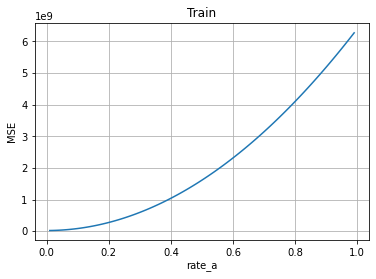

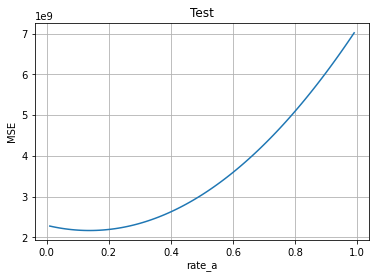

Min MSE = 2170419348.457741
rate = 0.14 : 0.86


In [16]:
blend_test(y_train, y_test, sv1_ypred_train, sv1_ypred, dt1_ypred_train, dt1_ypred)

### ★ブレンディングテスト(3)

標準化と対数変換でSVRの精度を上げてからブレンディングしてみる。

#### 【結果】
- SVR単体のMSE
  - 7,130,991,127　から　2,004,950,680　まで改善


- SVRと決定木回帰のブレンド　
  - (SVR：2,004,950,680, 決定木：2,297,233,115) から 1,713,975,932　まで改善


In [17]:
# SVR　学習・予測
np.random.seed(0)
sv2 = SVR()
sv2.fit(X_train_std, y_train_log)
sv2_ypred_train = sv2.predict(X_train_std)
sv2_ypred = sv2.predict(X_test_std)

sv2_ypred_train = np.exp(sv2_ypred_train)
sv2_ypred = np.exp(sv2_ypred)

# MSE
print_mse(y_train, sv2_ypred_train, y_test, sv2_ypred)

MSE(平均二乗誤差)(train) : 1,455,490,278.844
MSE(平均二乗誤差)(test) : 2,004,950,680.881


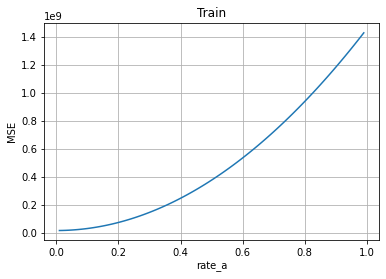

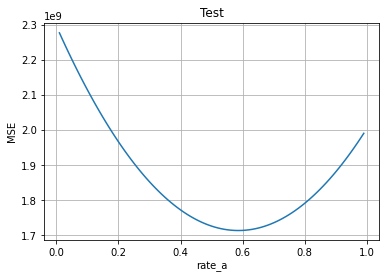

Min MSE = 1713975932.4190412
rate = 0.59 : 0.41


In [18]:
blend_test(y_train, y_test, sv2_ypred_train, sv2_ypred, dt1_ypred_train, dt1_ypred)

In [19]:
# ブレンディング
rate_a = 0.6
rate_b = 1 - rate_a

blend3_ypred_train = sv2_ypred_train*rate_a + dt1_ypred_train*rate_b
blend3_ypred = sv2_ypred*rate_a + dt1_ypred*rate_b

# MSE
print_mse(y_train, blend3_ypred_train, y_test, blend3_ypred)

MSE(平均二乗誤差)(train) : 536,040,177.808
MSE(平均二乗誤差)(test) : 1,714,279,813.485


### ★ブレンディングテスト(4)

ブレンディングテスト(3)の結果をさらに線形回帰とブレンディングしてみる。


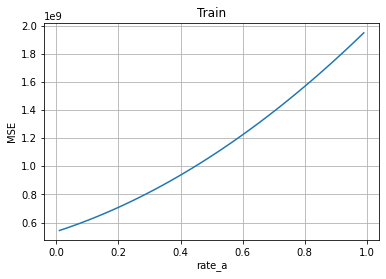

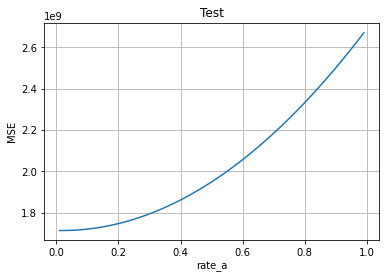

Min MSE = 1713963056.3475692
rate = 0.02 : 0.98


In [20]:
blend_test(y_train, y_test, lr1_ypred_train, lr1_ypred, blend3_ypred_train, blend3_ypred)

### ★ブレンディングテスト(5)

決定木回帰のハイパーパラメータをチューニングして再実行

#### 【結果】
MSE（SVR：2,004,950,680、決定木：1,977,594,246）から　1,857,927,485.997　まで改善

決定木単体の精度はテスト(3)のときより高いが、ブレンディング結果はテスト(3)より悪かった。

単純にモデル単体の精度を上げればよいというわけではなさそう。

気になるのはトレーニングデータのブレンディング時の推移グラフの形状が他のテスト時と異なる点。

In [21]:
# 線形回帰　学習・予測
np.random.seed(0)
dt2 = DecisionTreeRegressor(criterion='mse')
dt2.fit(X_train, y_train)
dt2_ypred_train = dt2.predict(X_train)
dt2_ypred = dt2.predict(X_test)

# MSE
print_mse(y_train, dt2_ypred_train, y_test, dt2_ypred)

MSE(平均二乗誤差)(train) : 18,849,495.975
MSE(平均二乗誤差)(test) : 2,297,233,115.183


In [22]:
# グリッドサーチ
param_grid = {'max_depth': [2,3,4,5,6,7,8,9],
              'min_samples_leaf': [5,6,7,8,9,10,11,12,13,14,15],
             }
gs = GridSearchCV(dt2, param_grid, cv=5)
gs.fit(X_train, y_train)
dt2_ypred_train = gs.predict(X_train)
dt2_ypred = gs.predict(X_test)

# best estimator
print(gs.best_estimator_)

# MSE
print_mse(y_train, dt2_ypred_train, y_test, dt2_ypred)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=14)
MSE(平均二乗誤差)(train) : 1,422,020,940.580
MSE(平均二乗誤差)(test) : 1,977,594,246.237


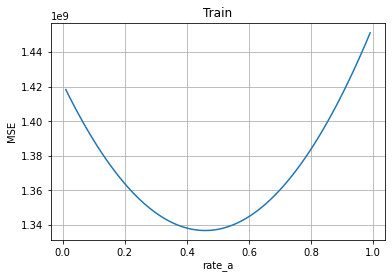

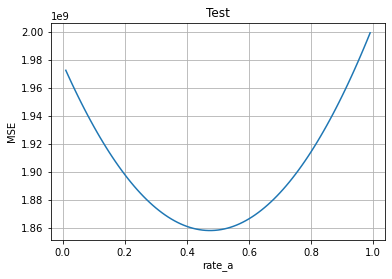

Min MSE = 1857927485.9970732
rate = 0.47 : 0.53


In [23]:
blend_test(y_train, y_test, sv2_ypred_train, sv2_ypred, dt2_ypred_train, dt2_ypred)

In [24]:
# ブレンディング
rate_a = 0.47
rate_b = 1 - rate_a

blend5_ypred_train = sv2_ypred_train*rate_a + dt2_ypred_train*rate_b
blend5_ypred = sv2_ypred*rate_a + dt2_ypred*rate_b

# MSE
print_mse(y_train, blend5_ypred_train, y_test, blend5_ypred)

MSE(平均二乗誤差)(train) : 1,336,887,099.306
MSE(平均二乗誤差)(test) : 1,857,927,485.997


### ★ブレンディングテスト(6)
線形回帰とSVRをブレンディング。似たもの同士？な気がするため、結果がどうなるかを確認。

#### 【結果】
特に改善しなかった。

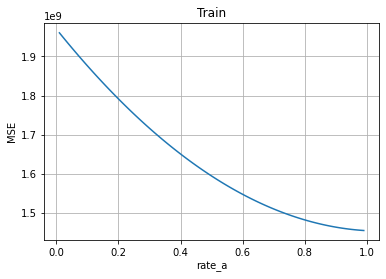

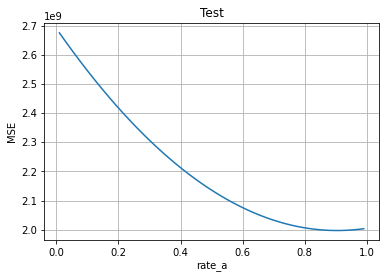

Min MSE = 1997178459.042387
rate = 0.90 : 0.10


In [25]:
blend_test(y_train, y_test, sv2_ypred_train, sv2_ypred, lr1_ypred_train, lr1_ypred)

## 4.バギング

## 【問題2】バギングのスクラッチ実装

バギング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。

### バギングとは
バギングは入力データの選び方を多様化する方法です。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ ブートストラップサンプル ）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。


sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation


scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができます。これによりブートストラップサンプルが手に入ります。


推定結果の平均をとる部分はブースティングと同様の実装になります。

In [26]:
def bagging_model(X_train, X_test, y_train, y_test, model='LinearRegression', samples=3, split_size=0.5, random_state=0):
    
    np.random.seed(0)
    if model == 'LinearRegression':
        model = LinearRegression()
    elif model == 'SVR':
        model = SVR()
    elif model == 'DecisionTreeRegressor':
        model = DecisionTreeRegressor()
        
    bagging_scores = {}
    bagging_scores_train = {}
    
    y_pred = None
    y_pred_train = None

    for i in range(samples):
        # ブートストラップサンプル
        _, bootstrap_X, _, bootstrap_y = train_test_split(X_train, y_train, shuffle=True, test_size=split_size, random_state=random_state+i)
        
        # 学習・予測
        model.fit(bootstrap_X, bootstrap_y)
        if np.all(y_pred == None):
            y_pred = np.array(model.predict(X_test))
            y_pred_train = np.array(model.predict(bootstrap_X))
        else:
            y_pred += np.array(model.predict(X_test))
            y_pred_train += np.array(model.predict(bootstrap_X))
        
    # 最終的な予測値
    y_pred = y_pred / samples
    y_pred_train = y_pred_train / samples
    
    return y_pred, y_pred_train

In [27]:
bg1_ypred, bg1_ypred_train = bagging_model(X_train, X_test, y_train, y_test, model='LinearRegression', samples=10, split_size=0.5, random_state=0)
mse = metrics.mean_squared_error(y_test, bg1_ypred)
print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(mse))

MSE(平均二乗誤差)(test) : 2,700,473,388.022


In [28]:
bg2_ypred, bg2_ypred_train = bagging_model(X_train_std, X_test_std, y_train_log, y_test_log, model='SVR', samples=10, split_size=0.5, random_state=0)
mse = metrics.mean_squared_error(y_test, bg2_ypred)
print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(mse))

MSE(平均二乗誤差)(test) : 39,800,479,453.907


In [29]:
bg3_ypred, bg3_ypred_train = bagging_model(X_train, X_test, y_train, y_test, model='DecisionTreeRegressor', samples=10, split_size=0.5, random_state=0)
mse = metrics.mean_squared_error(y_test, bg3_ypred)
print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(mse))

MSE(平均二乗誤差)(test) : 1,699,761,406.641


### ★個人テスト　上記「線形回帰」「決定木回帰」をブレンディング

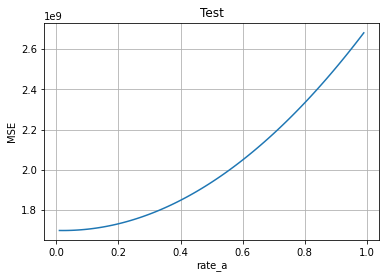

Min MSE = 1699292155.7618823
rate = 0.02 : 0.98


In [30]:
blend_test(y_train, y_test, bg1_ypred_train, bg1_ypred, bg3_ypred_train, bg3_ypred, train=False)

## 5.スタッキング

## 【問題3】スタッキングのスクラッチ実装
スタッキング をスクラッチ実装し、単一モデルより精度があがる例を 最低1つ 示してください。



### スタッキングとは
スタッキングの手順は以下の通りです。最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。まずは 
K
0
=
3
,
M
0
=
2
 程度にします。



《学習時》


（ステージ 
0
 ）


学習データを 
K
0
 個に分割する。
分割した内の 
(
K
0
−
1
)
 個をまとめて学習用データ、残り 
1
 個を推定用データとする組み合わせが 
K
0
 個作れる。
あるモデルのインスタンスを 
K
0
 個用意し、異なる学習用データを使い学習する。
それぞれの学習済みモデルに対して、使っていない残り 
1
 個の推定用データを入力し、推定値を得る。（これをブレンドデータと呼ぶ）
さらに、異なるモデルのインスタンスも 
K
0
 個用意し、同様のことを行う。モデルが 
M
0
 個あれば、 
M
0
 個のブレンドデータが得られる。

（ステージ 
n
 ）


ステージ 
n
−
1
 のブレンドデータを
M
n
−
1
 次元の特徴量を持つ学習用データと考え、 
K
n
 個に分割する。以下同様である。

（ステージ 
N
 ）＊最後のステージ


ステージ 
N
−
1
 の 
M
N
−
1
 個のブレンドデータを
M
N
−
1
 次元の特徴量の入力として、1種類のモデルの学習を行う。これが最終的な推定を行うモデルとなる。


《推定時》


（ステージ 
0
 ）


テストデータを 
K
0
×
M
0
 個の学習済みモデルに入力し、
K
0
×
M
0
 個の推定値を得る。これを 
K
0
 の軸で平均値を求め 
M
0
 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ 
n
 ）


ステージ 
n
−
1
 で得たブレンドテストを 
K
n
×
M
n
 個の学習済みモデルに入力し、
K
n
×
M
n
 個の推定値を得る。これを 
K
n
 の軸で平均値を求め 
M
0
 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ 
N
 ）＊最後のステージ


ステージ 
N
−
1
 で得たブレンドテストを学習済みモデルに入力し、推定値を得る。

### 学習のコード

In [40]:
def stage_0(df, target_column, k=3):
    X = np.array(df.drop(target_column, axis=1))
    y = np.array(df[target_column])
    n_samples = len(y)
    all_idx = np.arange(n_samples)
    div_idx = np.array_split(all_idx, k)
    
    model_list = ['LinearRegression',
                  'SVR',
                  'DecisionTreeRegressor']
    
    
    preds = np.zeros([n_samples, len(model_list)])
    
    for i, model in enumerate(model_list):
        blend_data = np.zeros(n_samples)
        
        if model == 'LinearRegression':
            model = LinearRegression()
        elif model == 'SVR':
            model = SVR(kernel='poly')
        elif model == 'DecisionTreeRegressor':
            model = DecisionTreeRegressor()

        for j in range(k):
            other_idx = np.delete(all_idx, div_idx[j])
            X_train, X_test = X[other_idx, :], X[div_idx[j]]
            y_train, y_test = y[other_idx], y[div_idx[j]]
            
            model.fit(X_train, y_train)
            blend_data[div_idx[j]] = model.predict(X_test)
            
            mse = metrics.mean_squared_error(y_test, blend_data[div_idx[j]])
            print('**********', model_list[i], '-', j, '**********')
            print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(mse))
            
        preds[:, i] = blend_data

    
    
    # ラストステージ？
    X_train, X_test, y_train, y_test = train_test_split(preds, y, test_size=0.3, random_state=0)
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    last_pred_train = model.predict(X_train)
    last_pred = model.predict(X_test)
    
    return last_pred, last_pred_train


In [41]:
pred, pred_train = stage_0(df, 'SalePrice', k=5)

********** LinearRegression - 0 **********
MSE(平均二乗誤差)(test) : 1,745,698,833.647
********** LinearRegression - 1 **********
MSE(平均二乗誤差)(test) : 2,247,973,650.723
********** LinearRegression - 2 **********
MSE(平均二乗誤差)(test) : 2,322,281,156.432
********** LinearRegression - 3 **********
MSE(平均二乗誤差)(test) : 1,802,749,841.139
********** LinearRegression - 4 **********
MSE(平均二乗誤差)(test) : 2,967,268,366.711
********** SVR - 0 **********
MSE(平均二乗誤差)(test) : 2,259,369,590.808
********** SVR - 1 **********
MSE(平均二乗誤差)(test) : 3,523,203,050.976
********** SVR - 2 **********
MSE(平均二乗誤差)(test) : 3,088,147,521.192
********** SVR - 3 **********
MSE(平均二乗誤差)(test) : 2,477,158,690.367
********** SVR - 4 **********
MSE(平均二乗誤差)(test) : 5,348,213,006.275
********** DecisionTreeRegressor - 0 **********
MSE(平均二乗誤差)(test) : 2,783,926,299.586
********** DecisionTreeRegressor - 1 **********
MSE(平均二乗誤差)(test) : 3,577,341,202.672
********** DecisionTreeRegressor - 2 **********
MSE(平均二乗誤差)(test) : 2,835,044,564.3

In [42]:
print_mse(y_train, pred_train, y_test, pred)

MSE(平均二乗誤差)(train) : 346,185.176
MSE(平均二乗誤差)(test) : 3,538,413,341.799


### 最終コード

In [70]:
class ScratchStacking():
    """
    スタッキング

    Parameters
    ----------

    """
    def __init__(self, k=3, verbose=False, verbose_interval=1, random_state=None, gs=False):
        # ハイパーパラメータを属性として記録
        self.k = k
        self.verbose = verbose
        self.verbose_interval = verbose_interval
        self.random_state = random_state
        self.next_stage = None
        self.gs = gs
        
    def fit(self, X, y):
        """
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        
        X = np.array(X)
        y = np.array(y)
        
        self.n_samples = len(X)
        self.n_models = 3
        self.blend_data = np.zeros([self.n_samples, self.n_models])
        
        # 学習
        self.trainingForStacking = TrainingForStacking(self.n_samples, self.n_models, self.k, self.verbose, self.verbose_interval, self.random_state)
        self.blend_data = self.trainingForStacking._stage_n(X, y, self.blend_data)
        
        # 学習（ラストステージ）
        self.trainingForStacking._last_stage(self.blend_data, y, self.gs)
        
        #verboseをTrueにした際は学習過程を出力
#         if self.verbose and i % self.verbose_interval == 0:
            

    def predict(self, X):
        """
        推定
        """
        preds = np.zeros([len(X), self.n_models])
        pre_pred = self.trainingForStacking._predict_stage_n(X, preds) / self.n_samples
        pred = self.trainingForStacking._predict_last_stage(pre_pred)
        
        return pred

In [98]:
class TrainingForStacking():
    def __init__(self, n_samples, n_models, k, verbose, verbose_interval, random_state):
        # ハイパーパラメータを属性として記録
        self.k = k
        self.verbose = verbose
        self.verbose_interval = verbose_interval
        self.random_state = random_state
        self.next_stage = None
        self.model_list = ['LinearRegression',
                           'SVR',
                           'DecisionTreeRegressor']
        self.n_samples = n_samples
        self.n_models = n_models
        self.all_idx = np.arange(self.n_samples)
        self.div_idx = np.array_split(self.all_idx, self.k)
        
        self.stop = False
        
    def _stage_n(self, X, y, blend_data, div_no=0):
        self.div_no = div_no
        self.blend_data = blend_data.copy()
        
        self.other_idx = np.delete(self.all_idx, self.div_idx[self.div_no])
        
        X_train, X_test = X[self.other_idx, :], X[self.div_idx[self.div_no]]
        y_train, y_test = y[self.other_idx], y[self.div_idx[self.div_no]]
        
        self.model_0 = LinearRegression()
        self.model_1 = SVR(kernel='poly')
        self.model_2 = DecisionTreeRegressor()

        self.model_0.fit(X_train, y_train)
        self.model_1.fit(X_train, y_train)
        self.model_2.fit(X_train, y_train)
        
        self.blend_data[self.div_idx[self.div_no], 0] = self.model_0.predict(X_test)
        self.blend_data[self.div_idx[self.div_no], 1] = self.model_1.predict(X_test)
        self.blend_data[self.div_idx[self.div_no], 2] = self.model_2.predict(X_test)
        
        self.mse_0 = metrics.mean_squared_error(y_test, self.blend_data[self.div_idx[self.div_no], 0])
        self.mse_1 = metrics.mean_squared_error(y_test, self.blend_data[self.div_idx[self.div_no], 1])
        self.mse_2 = metrics.mean_squared_error(y_test, self.blend_data[self.div_idx[self.div_no], 2])

        if self.verbose:
            print('**********', self.model_list[0], '-', self.div_no, '**********')
            print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(self.mse_0))
            print('**********', self.model_list[1], '-', self.div_no, '**********')
            print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(self.mse_1))
            print('**********', self.model_list[2], '-', self.div_no, '**********')
            print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(self.mse_2))
        
        self.div_no += 1
        if self.div_no >= self.k:
            self.stop = True
            return self.blend_data
        self.next_stage = TrainingForStacking(self.n_samples, self.n_models, self.k, self.verbose, self.verbose_interval, self.random_state)
        self.blend_data = self.next_stage._stage_n(X, y, self.blend_data, self.div_no)
        return self.blend_data

        
        
    def _last_stage(self, blend_data, y, gs):
        X_train, X_test, y_train, y_test = train_test_split(blend_data, y, test_size=0.3, random_state=0)
        self.model_last = DecisionTreeRegressor()
        if gs:
            param_grid = {'max_depth': [2,3,4,5,6,7,8,9,10],
                          'min_samples_leaf': [5,6,7,8,9,10,11,12,13,14,15]
                         }
            gs = GridSearchCV(self.model_last, param_grid, cv=5)
            gs.fit(X_train, y_train)
            last_pred_train = gs.predict(X_train)
            last_pred = gs.predict(X_test)
            self.model_last = gs
        else:
            self.model_last.fit(X_train, y_train)
            last_pred_train = self.model_last.predict(X_train)
            last_pred = self.model_last.predict(X_test)
        if self.verbose:
            print('\n')
            print('Last Stage :')
            print_mse(y_train, last_pred_train, y_test, last_pred)
            
            
    def _predict_stage_n(self, X, preds):
        if self.stop:
            return preds
        else:
            preds[:, 0] += self.model_0.predict(X)
            preds[:, 1] += self.model_1.predict(X)
            preds[:, 2] += self.model_2.predict(X)
            return self.next_stage._predict_stage_n(X, preds)
        
    def _predict_last_stage(self, X):
        pred = self.model_last.predict(X)
        return pred


In [85]:
# データ分割
X_train, X_test, y_train, y_test = train_test_split(df[['GrLivArea', 'YearBuilt']], df['SalePrice'], test_size=.3, random_state=0)

In [95]:
ss = ScratchStacking(k=5, verbose=True, gs=True)
ss.fit(X_train, y_train)

********** LinearRegression - 0 **********
MSE(平均二乗誤差)(test) : 2,297,867,235.649
********** SVR - 0 **********
MSE(平均二乗誤差)(test) : 3,808,744,646.242
********** DecisionTreeRegressor - 0 **********
MSE(平均二乗誤差)(test) : 4,186,186,631.498
********** LinearRegression - 1 **********
MSE(平均二乗誤差)(test) : 1,895,745,272.664
********** SVR - 1 **********
MSE(平均二乗誤差)(test) : 3,067,905,508.739
********** DecisionTreeRegressor - 1 **********
MSE(平均二乗誤差)(test) : 2,689,284,028.190
********** LinearRegression - 2 **********
MSE(平均二乗誤差)(test) : 2,677,489,848.292
********** SVR - 2 **********
MSE(平均二乗誤差)(test) : 3,398,201,564.188
********** DecisionTreeRegressor - 2 **********
MSE(平均二乗誤差)(test) : 4,227,773,387.846
********** LinearRegression - 3 **********
MSE(平均二乗誤差)(test) : 1,672,541,623.373
********** SVR - 3 **********
MSE(平均二乗誤差)(test) : 2,434,753,407.411
********** DecisionTreeRegressor - 3 **********
MSE(平均二乗誤差)(test) : 2,298,260,048.863
********** LinearRegression - 4 **********
MSE(平均二乗誤差)(test)

In [96]:
ss_pred = ss.predict(X_test)

In [97]:
mse = metrics.mean_squared_error(y_test, ss_pred)
print('MSE(平均二乗誤差)(test) : {:,.3f}'.format(mse))

MSE(平均二乗誤差)(test) : 17,703,890,964.843
